# Move files around

In [1]:
import os
import shutil

# define directory paths
base_path = "C-NMC_Leukemia"
training_data_path = os.path.join(base_path, "training_data")
all_folders = ["fold_0/all", "fold_1/all", "fold_2/all"]
hem_folders = ["fold_0/hem", "fold_1/hem", "fold_2/hem"]
new_all_path = os.path.join(training_data_path, "new_all")
new_hem_path = os.path.join(training_data_path, "new_hem")

In [2]:
# create new directories
os.makedirs(new_all_path, exist_ok=True)
os.makedirs(new_hem_path, exist_ok=True)

In [3]:
# move all image files from 'all' folders to 'new_all' directory
for folder_path in all_folders:
    folder = os.path.join(training_data_path, folder_path)
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        shutil.move(file_path, new_all_path)
        
print("Image files moved successfully.")

Image files moved successfully.


In [4]:
# move all image files from 'hem' folders to 'new_hem' directory
for folder_path in hem_folders:
    folder = os.path.join(training_data_path, folder_path)
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        shutil.move(file_path, new_hem_path)
        
print("Image files moved successfully.")

Image files moved successfully.


In [5]:
# remove all the empty directories after moving the images
shutil.rmtree(training_data_path+'/fold_0')
shutil.rmtree(training_data_path+'/fold_1')
shutil.rmtree(training_data_path+'/fold_2')

# Visualizing Data Imabalance ⚖️
An imbalanced dataset is one where the number of examples in each class or category is significantly different. 

For example, in our case, we are building a model to classify images of ALL and Hem, but we have many more images of ALL than Hem.

In [6]:
total_all_files=len(os.listdir(new_all_path))
total_hem_files=len(os.listdir(new_hem_path))

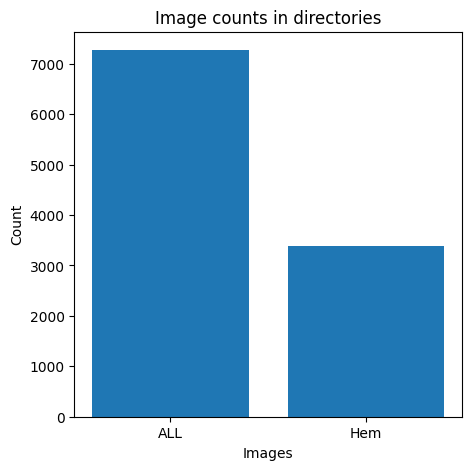

[7272, 3389]


In [7]:
import matplotlib.pyplot as plt

labels = ['ALL', 'Hem']
counts = [total_all_files, total_hem_files]
fig = plt.figure(figsize=(5, 5))
plt.bar(labels, counts)
plt.title('Image counts in directories')
plt.xlabel('Images')
plt.ylabel('Count')
plt.show()

print(counts)

- This can cause problems when training a deep learning model because the model will be biased towards the majority class, in this case, ALL.<br>
- The model may simply learn to always predict "ALL" because it is the most common class in the dataset, without really learning the distinguishing features of a Hem.

# Dealing with Imabalance- Data Augmentation
Data augmentation is a technique used in machine learning to increase the amount of training data by creating new examples from the existing data.

Data augmentation can help you generate new images from the existing ones by applying various transformations like flipping, rotating, cropping, zooming, or changing the brightness or contrast.

In [8]:
augmented_hem = os.path.join(training_data_path,"augmented_hem")

# create directory where we will store the augmented hem images
os.mkdir(augmented_hem)

In [9]:
# read Hem images from disk and store them in an array
import numpy as np
from skimage import io
from PIL import Image

hem_in_list=[]

hem_images_paths = os.listdir(new_hem_path)
for i, image_name in enumerate(hem_images_paths):
    if(image_name.split('.')[1] == 'bmp'):
        image = io.imread(new_hem_path+'/'+image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((210,210)) #210x210
        hem_in_list.append(np.array(image))

hem_in_array = np.array(hem_in_list)

In [10]:
# create an ImageDataGenerator object for data augmentation
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=35,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='reflect'
)

In [11]:
batches = 3883//32
batches

121

In [12]:
#start generating augmented images
i = 0
for batch in datagen.flow(hem_in_array,
                         batch_size=32,
                         save_to_dir=augmented_hem,
                         save_prefix='aug_',
                         save_format='bmp'):
    i+=1
    if i>121:
        break

print("Done!")

Done!


## Visualize images ratio after augmentation ⚖️

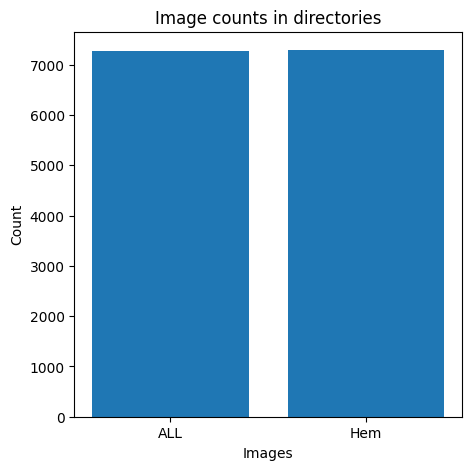

[7272, 7290]


In [13]:
total_all_files=len(os.listdir(new_all_path))
total_hem_files=len(os.listdir(new_hem_path))+len(os.listdir(augmented_hem))

labels = ['ALL', 'Hem']
counts = [total_all_files, total_hem_files]
fig = plt.figure(figsize=(5, 5))
plt.bar(labels, counts)
plt.title('Image counts in directories')
plt.xlabel('Images')
plt.ylabel('Count')
plt.show()

print(counts)

In [14]:
# move images from augmented_hem directory to new_hem directory
for filename in os.listdir(augmented_hem):
    file_path = os.path.join(augmented_hem, filename)
    shutil.move(file_path, new_hem_path)

# remove the augmented hem directory after moving the images
shutil.rmtree(augmented_hem)

print("Done!")

Done!


# Image Preprocessing

In [15]:
# read Hem images from disk and store them in an array
hem_in_list=[]

hem_images_paths = os.listdir(new_hem_path)
for i, image_name in enumerate(hem_images_paths):
    if(image_name.split('.')[1] == 'bmp'):
        image = io.imread(new_hem_path+'/'+image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((210,210)) #210x210
        hem_in_list.append(np.array(image))

hem_in_array = np.array(hem_in_list)

In [16]:
# read ALL images from disk and store them in an array
all_in_list=[]

all_images_paths = os.listdir(new_all_path)
for i, image_name in enumerate(all_images_paths):
    if(image_name.split('.')[1] == 'bmp'):
        image = io.imread(new_all_path+'/'+image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((210,210)) #210x210
        all_in_list.append(np.array(image))

all_in_array = np.array(all_in_list)

In [17]:
print(f"No. of Hem images: {len(hem_in_array)}")
print(f"No. of ALL images: {len(all_in_array)}")

No. of Hem images: 7290
No. of ALL images: 7272


## Crop the images ✂️

In [18]:
# define a function that takes in images array as input and return another array that has the images cropped
def crop(arr):
    """
    Function for cropping images.
    Input: Images array.
    Returns: Cropped Images array.
    """
    cropped_images=[]
    for each_image in arr:
        cropped_image = each_image[30:-30, 30:-30, :]
        cropped_images.append(cropped_image)
        
    cropped=np.array(cropped_images)
    return cropped

In [19]:
#crop ALL and Hem images
cropped_all_in_array = crop(all_in_array)
cropped_hem_in_array = crop(hem_in_array)

## Visualize Images before and after cropping 

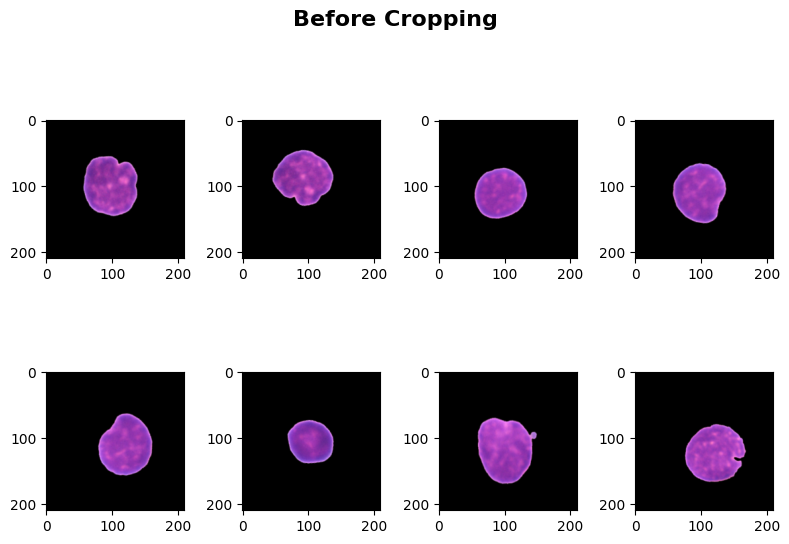

In [20]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(8, 6))

for i, ax in enumerate(axes.flat):
    if i in range(8):
        ax.imshow(hem_in_array[i], cmap='gray')
    else:
        ax.axis('off')
fig.suptitle('Before Cropping', fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()

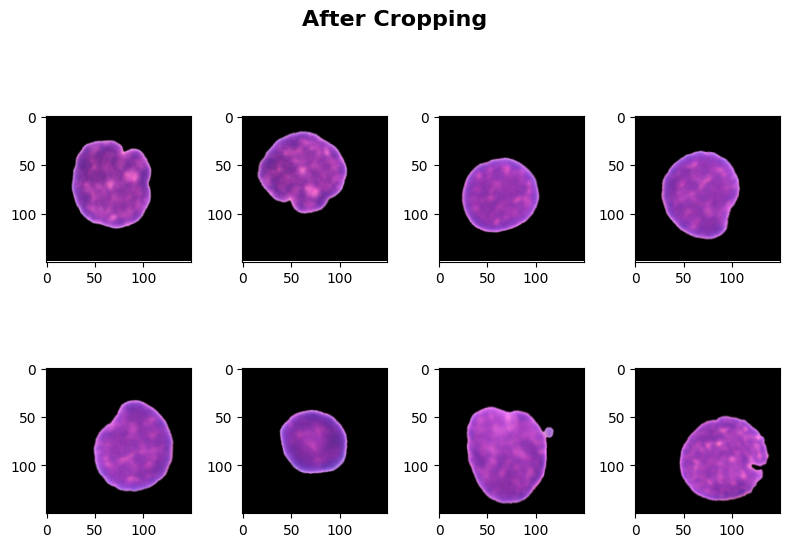

In [21]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(8, 6))

for i, ax in enumerate(axes.flat):
    if i in range(8):
        ax.imshow(cropped_hem_in_array[i], cmap='gray')
    else:
        ax.axis('off')
fig.suptitle('After Cropping', fontsize=16, fontweight='bold')
fig.tight_layout()
plt.show()